In [4]:
import math
import numpy as np
import bisect


class Spline:
    """
    Cubic Spline class
    """

    def __init__(self, x, y):
        self.b, self.c, self.d, self.w = [], [], [], []

        self.x = x
        self.y = y

        self.nx = len(x)  # dimension of x
        h = np.diff(x)

        # calc coefficient c
        self.a = [iy for iy in y]

        # calc coefficient c
        A = self.__calc_A(h)
        B = self.__calc_B(h)
        self.c = np.linalg.solve(A, B)
        #  print(self.c1)

        # calc spline coefficient b and d
        for i in range(self.nx - 1):
            self.d.append((self.c[i + 1] - self.c[i]) / (3.0 * h[i]))
            tb = (self.a[i + 1] - self.a[i]) / h[i] - h[i] * \
                (self.c[i + 1] + 2.0 * self.c[i]) / 3.0
            self.b.append(tb)

    def calc(self, t):
        """
        Calc position
        if t is outside of the input x, return None
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.a[i] + self.b[i] * dx + \
            self.c[i] * dx ** 2.0 + self.d[i] * dx ** 3.0

        return result

    def calcd(self, t):
        """
        Calc first derivative
        if t is outside of the input x, return None
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.b[i] + 2.0 * self.c[i] * dx + 3.0 * self.d[i] * dx ** 2.0
        return result

    def calcdd(self, t):
        """
        Calc second derivative
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = 2.0 * self.c[i] + 6.0 * self.d[i] * dx
        return result

    def __search_index(self, x):
        """
        search data segment index
        """
        return bisect.bisect(self.x, x) - 1

    def __calc_A(self, h):
        """
        calc matrix A for spline coefficient c
        """
        A = np.zeros((self.nx, self.nx))
        A[0, 0] = 1.0
        for i in range(self.nx - 1):
            if i != (self.nx - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])
            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[self.nx - 1, self.nx - 2] = 0.0
        A[self.nx - 1, self.nx - 1] = 1.0
        #  print(A)
        return A

    def __calc_B(self, h):
        """
        calc matrix B for spline coefficient c
        """
        B = np.zeros(self.nx)
        for i in range(self.nx - 2):
            B[i + 1] = 3.0 * (self.a[i + 2] - self.a[i + 1]) / \
                h[i + 1] - 3.0 * (self.a[i + 1] - self.a[i]) / h[i]
        return B


class Spline2D:
    """
    2D Cubic Spline class
    """

    def __init__(self, x, y):
        self.s = self.__calc_s(x, y)
        self.sx = Spline(self.s, x)
        self.sy = Spline(self.s, y)

    def __calc_s(self, x, y):
        dx = np.diff(x)
        dy = np.diff(y)
        self.ds = np.hypot(dx, dy)
        s = [0]
        s.extend(np.cumsum(self.ds))
        return s

    def calc_position(self, s):
        """
        calc position
        """
        x = self.sx.calc(s)
        y = self.sy.calc(s)

        return x, y

    def calc_curvature(self, s):
        """
        calc curvature
        """
        dx = self.sx.calcd(s)
        ddx = self.sx.calcdd(s)
        dy = self.sy.calcd(s)
        ddy = self.sy.calcdd(s)
        k = (ddy * dx - ddx * dy) / ((dx ** 2 + dy ** 2)**(3 / 2))
        return k

    def calc_yaw(self, s):
        """
        calc yaw
        """
        dx = self.sx.calcd(s)
        dy = self.sy.calcd(s)
        yaw = math.atan2(dy, dx)
        return yaw


def calc_spline_course(x, y, ds=0.1):
    sp = Spline2D(x, y)
    s = list(np.arange(0, sp.s[-1], ds))

    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))

    return rx, ry, ryaw, rk, s

LQR steering control tracking start!!


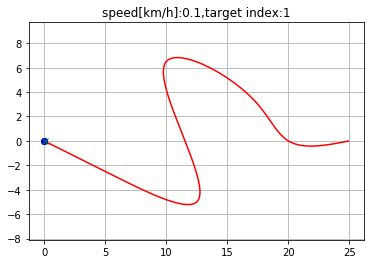

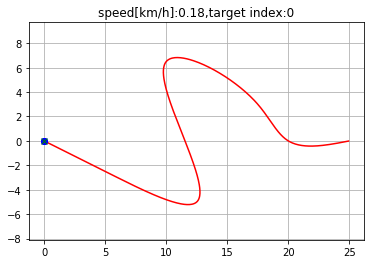

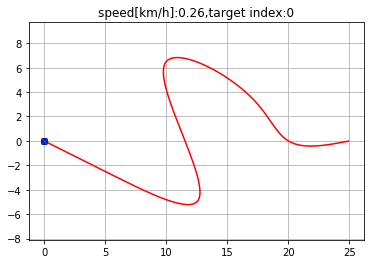

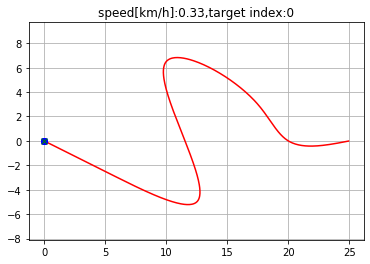

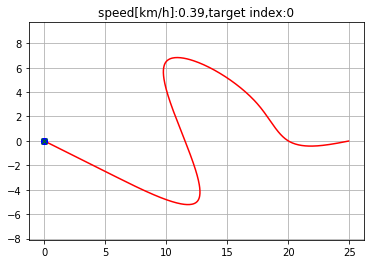

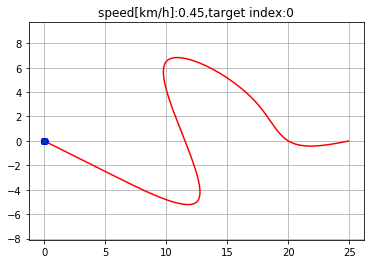

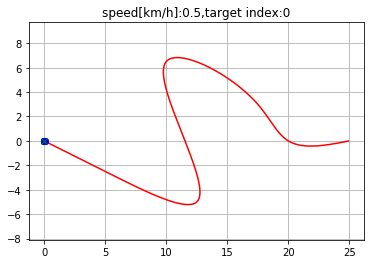

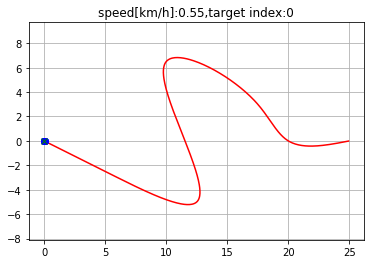

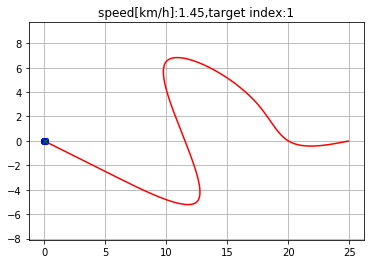

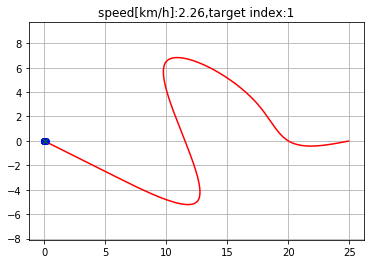

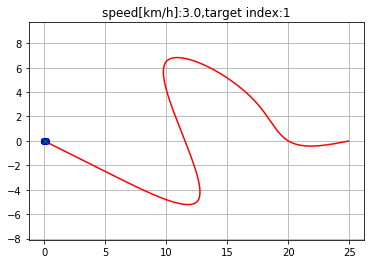

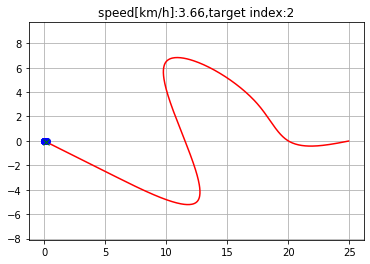

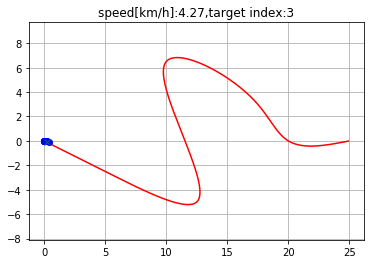

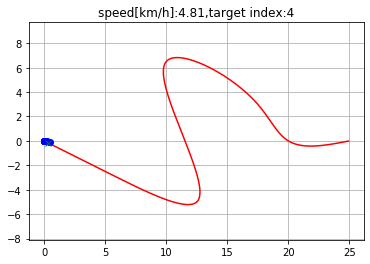

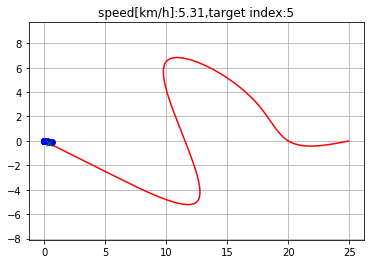

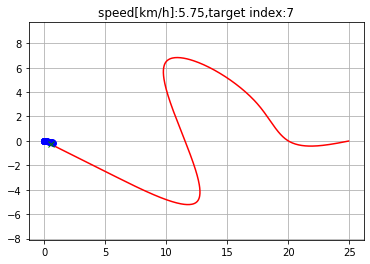

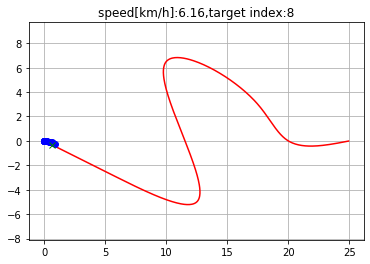

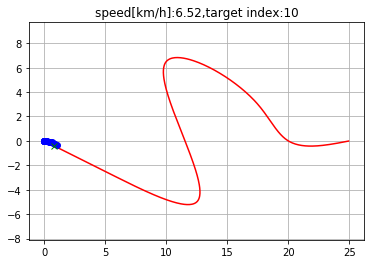

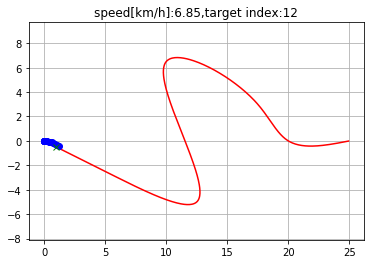

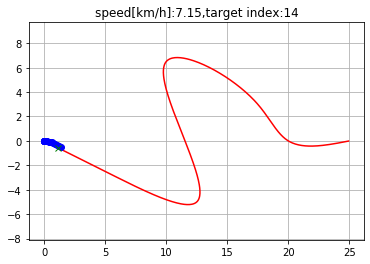

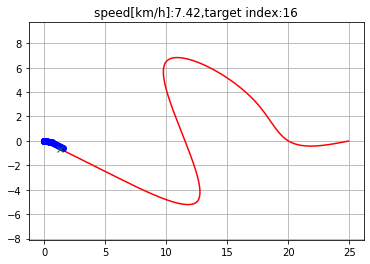

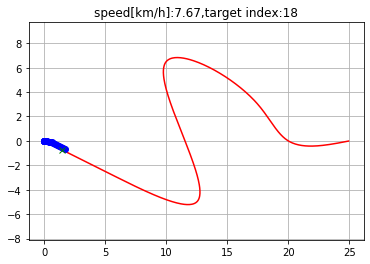

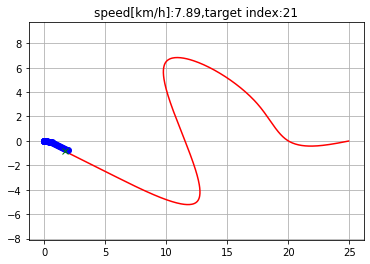

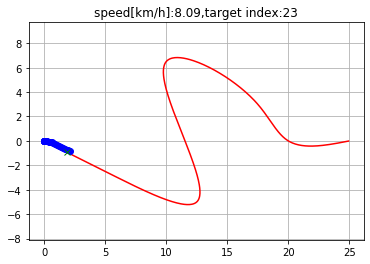

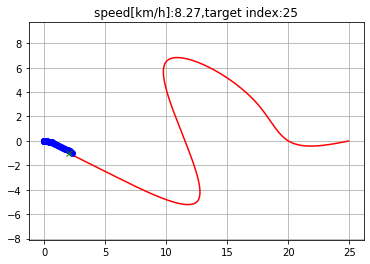

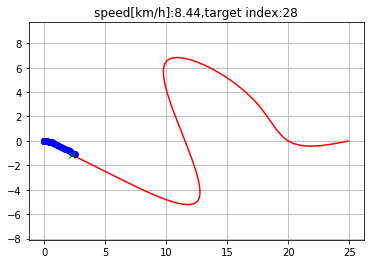

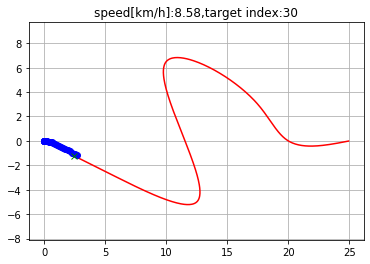

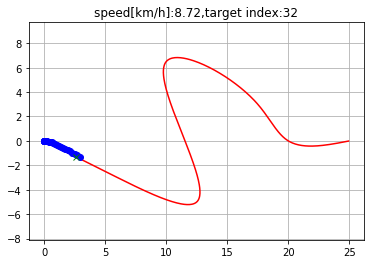

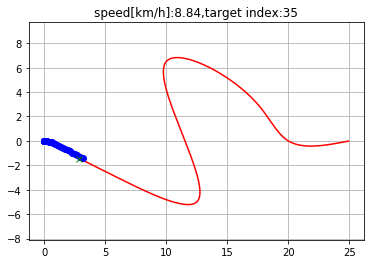

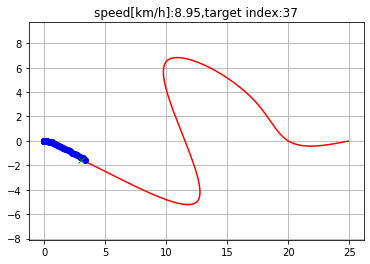

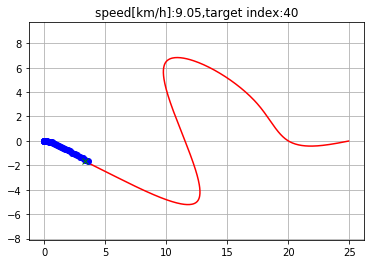

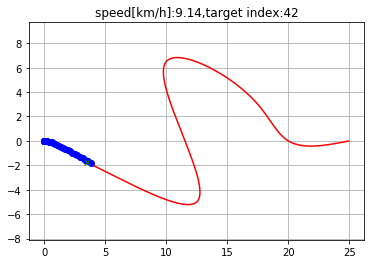

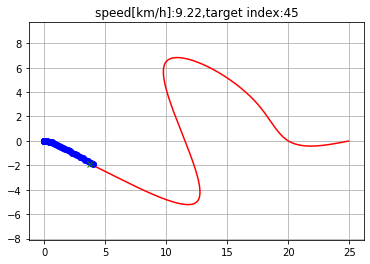

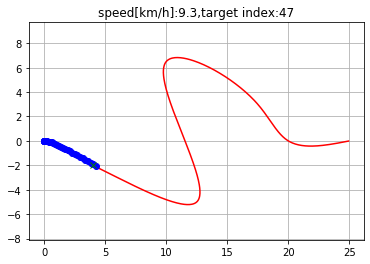

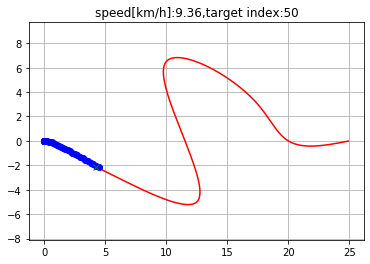

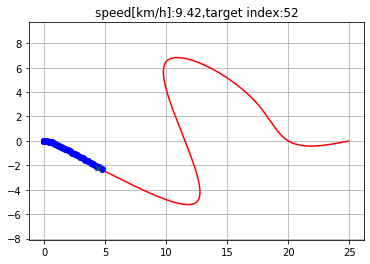

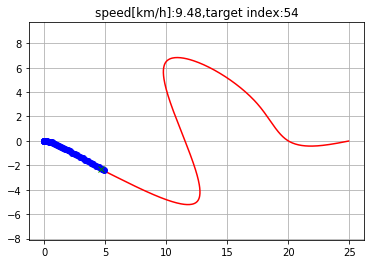

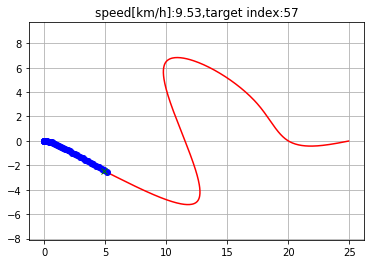

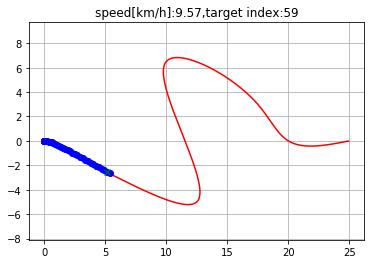

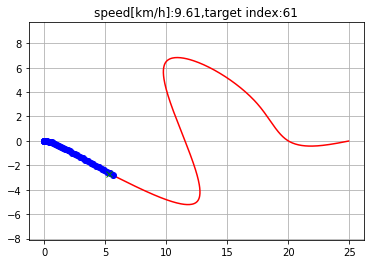

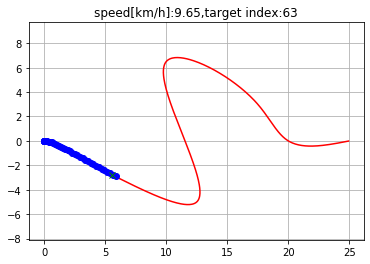

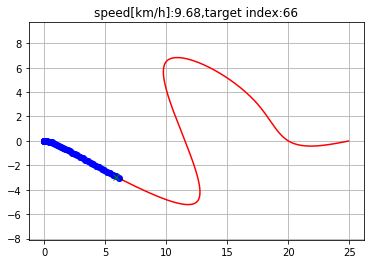

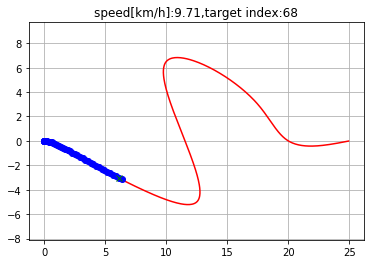

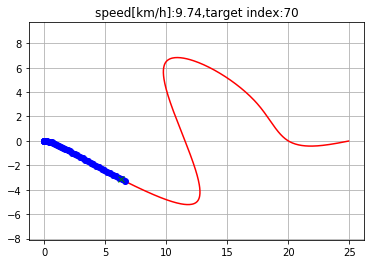

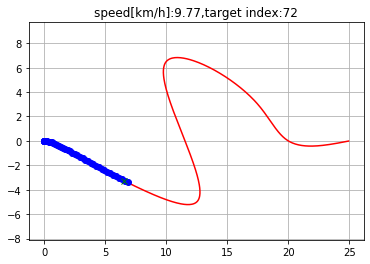

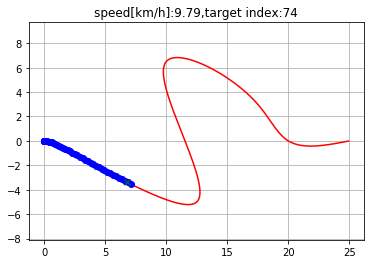

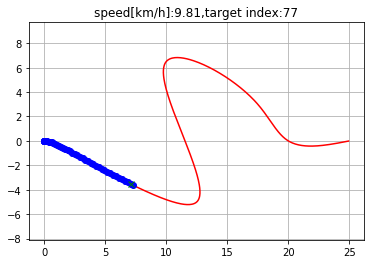

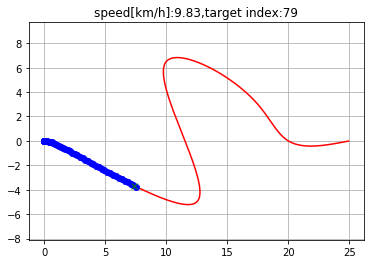

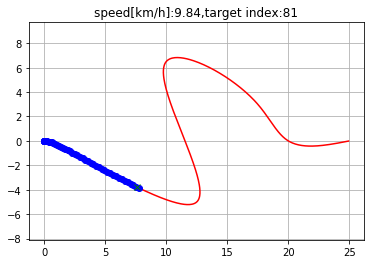

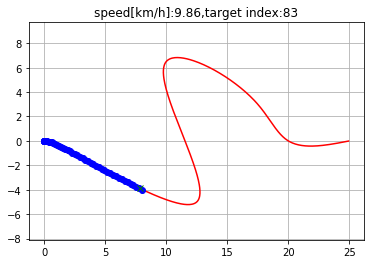

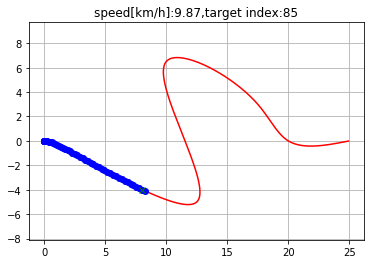

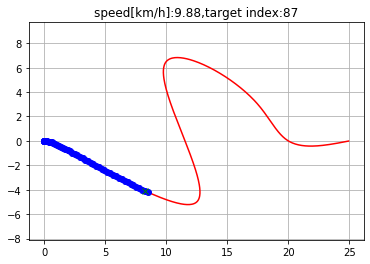

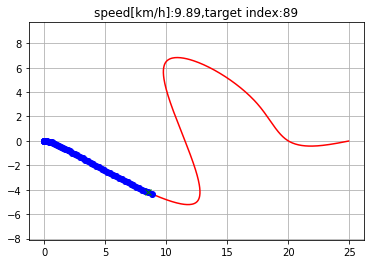

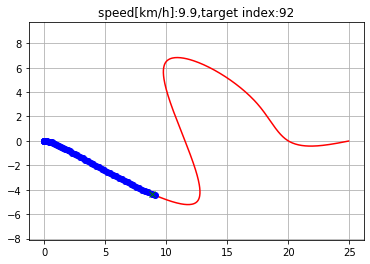

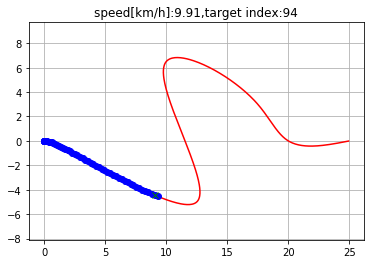

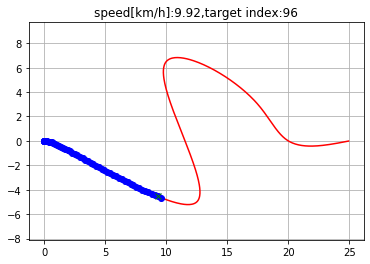

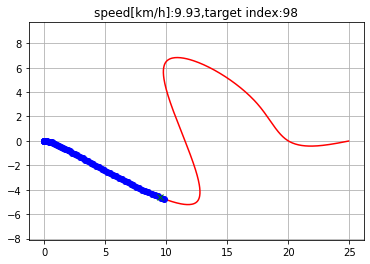

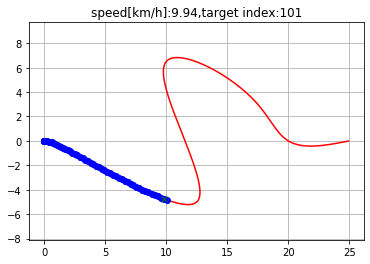

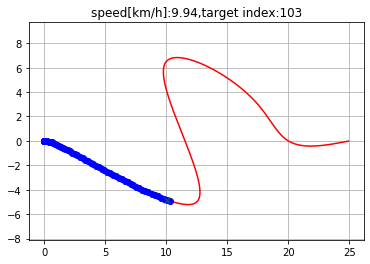

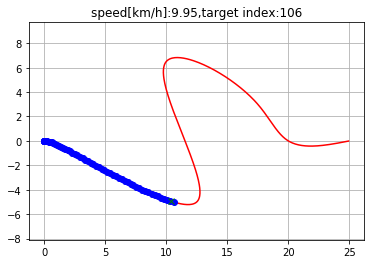

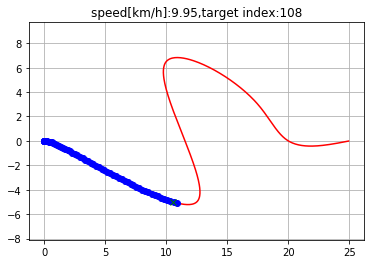

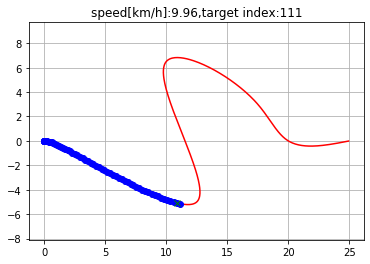

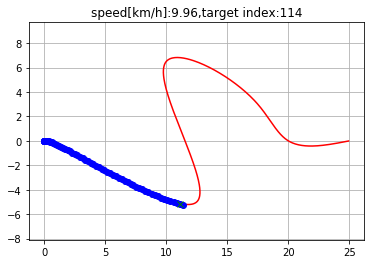

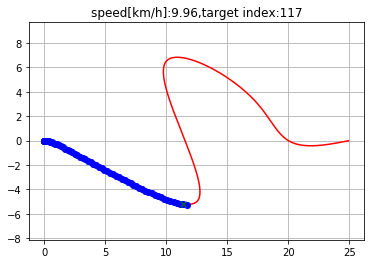

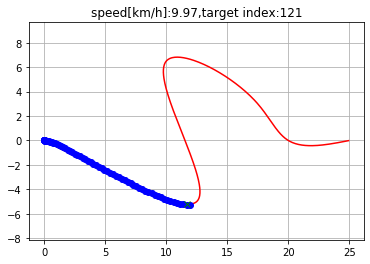

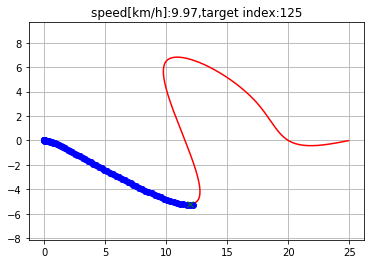

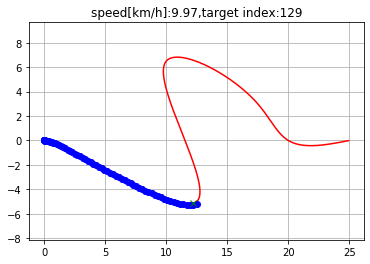

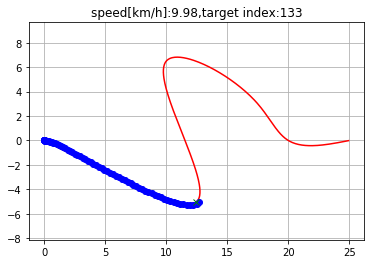

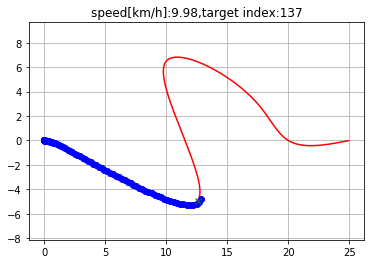

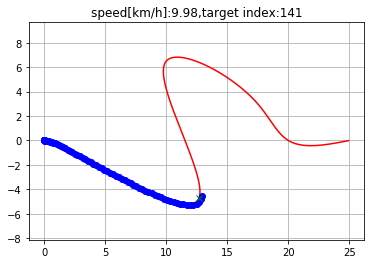

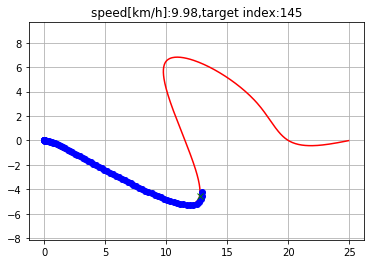

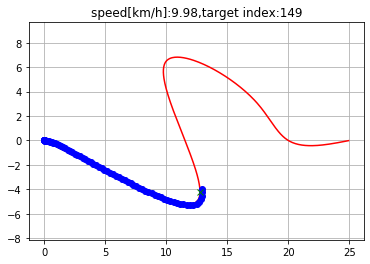

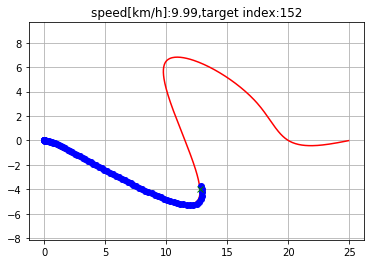

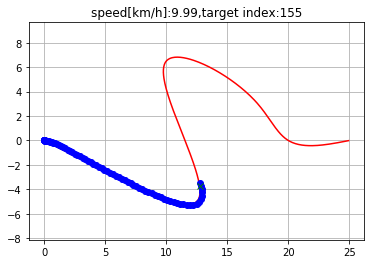

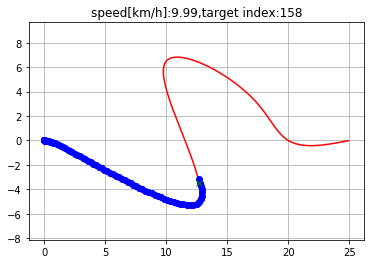

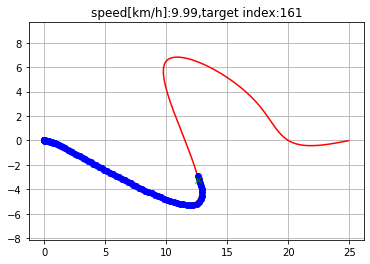

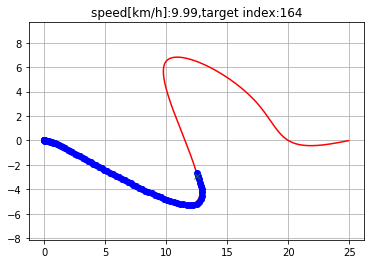

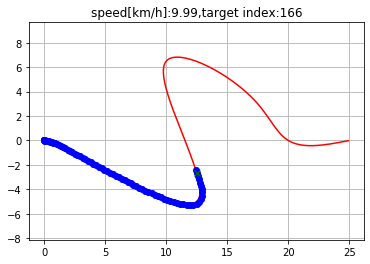

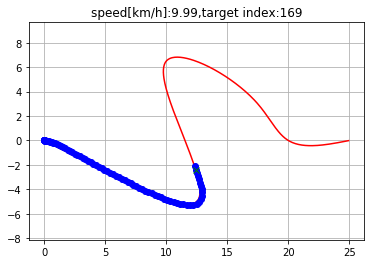

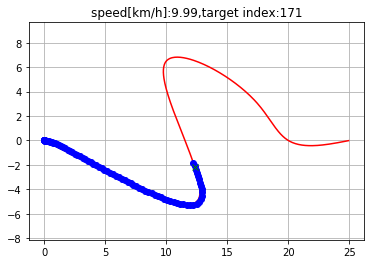

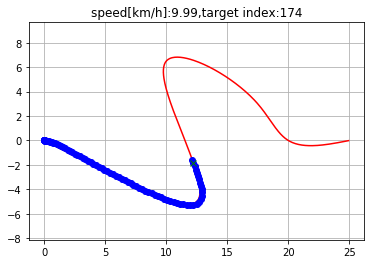

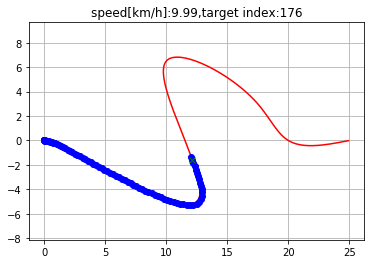

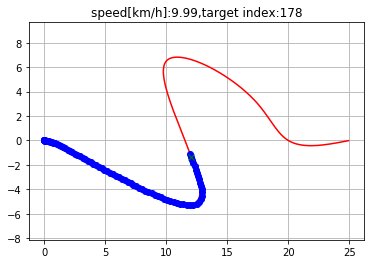

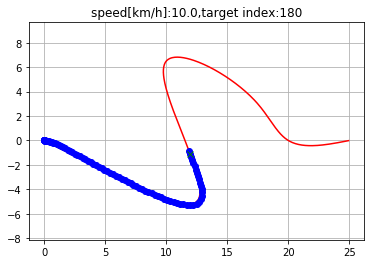

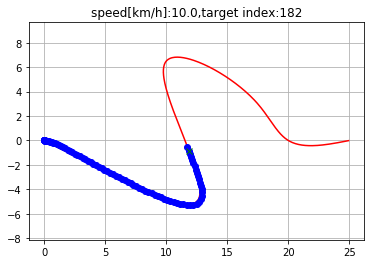

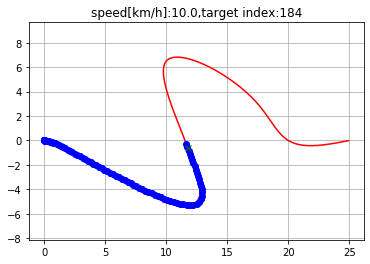

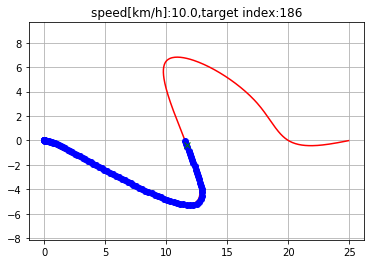

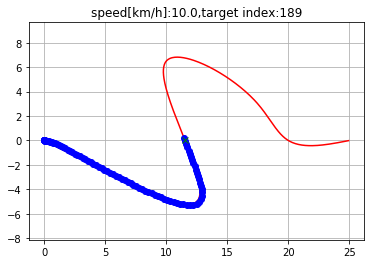

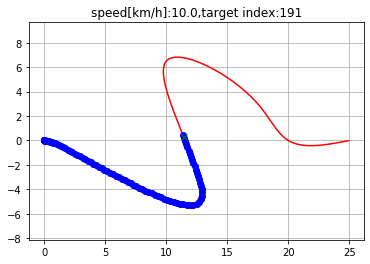

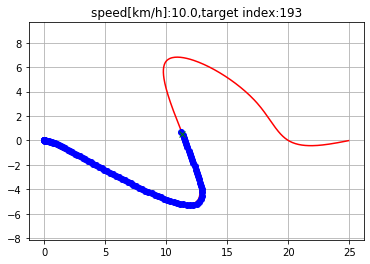

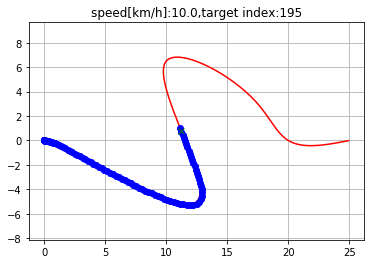

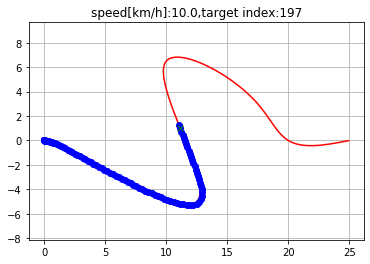

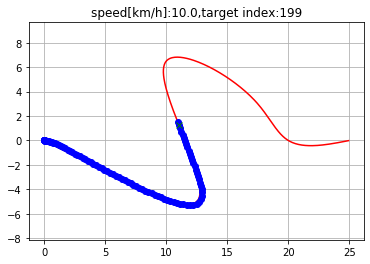

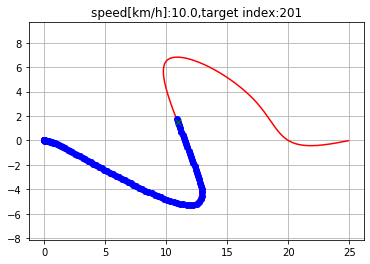

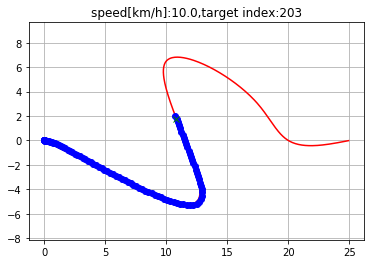

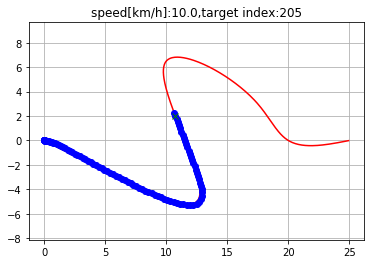

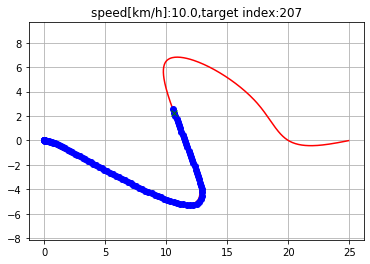

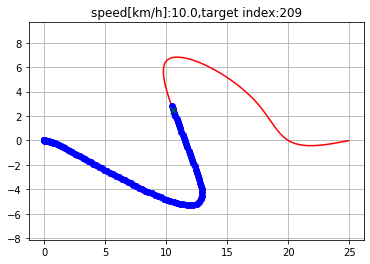

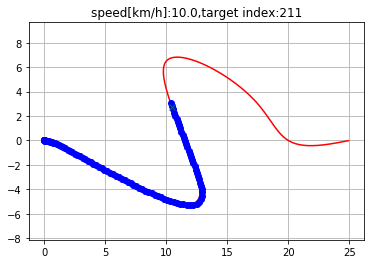

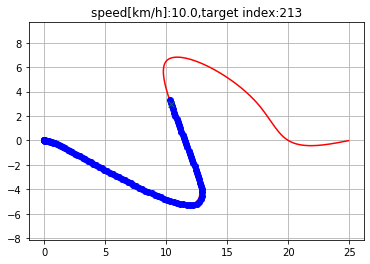

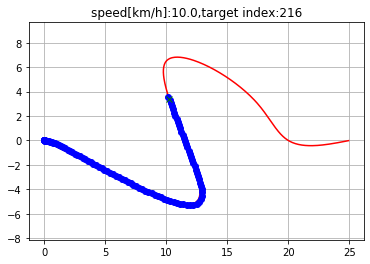

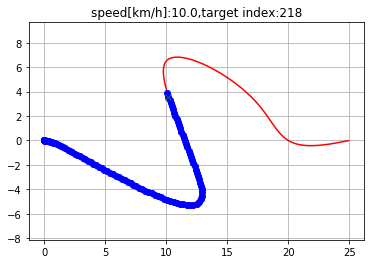

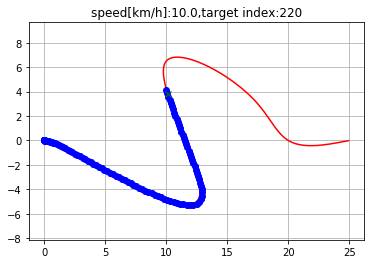

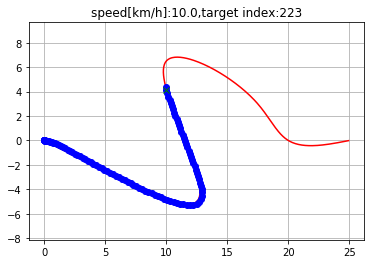

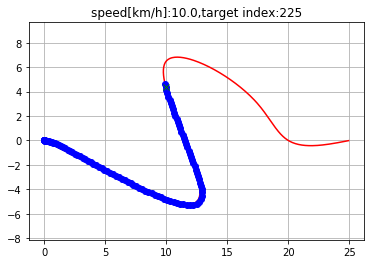

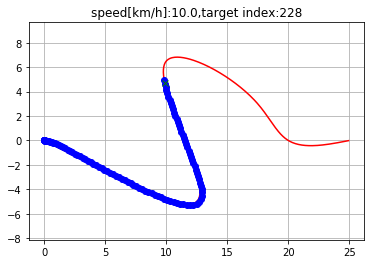

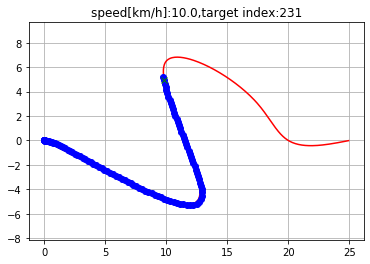

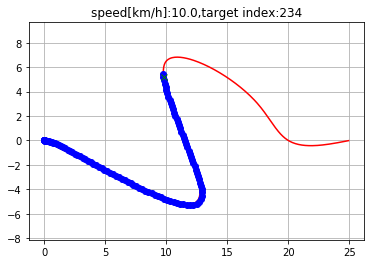

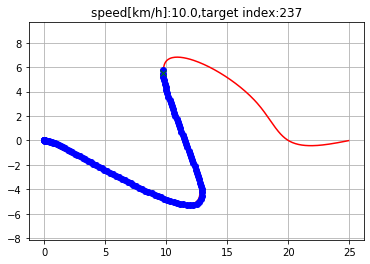

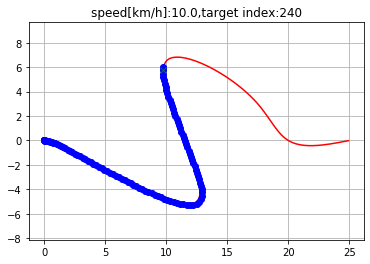

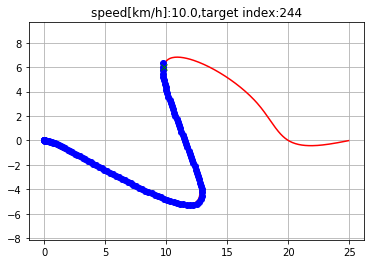

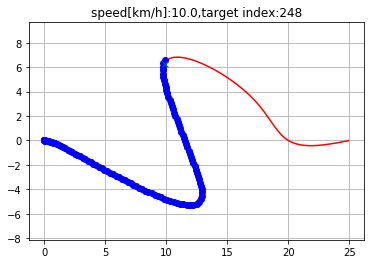

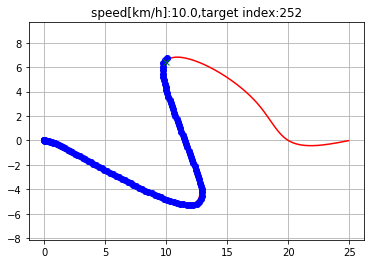

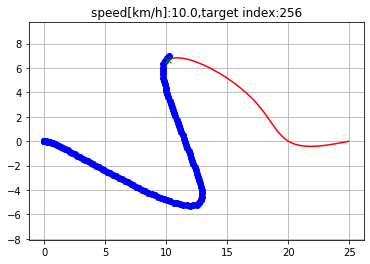

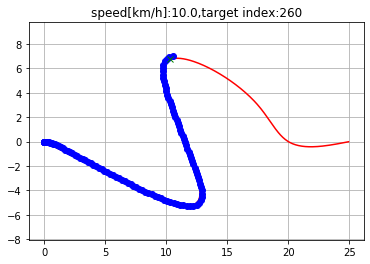

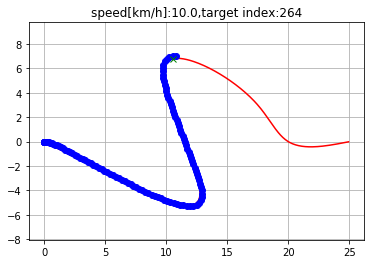

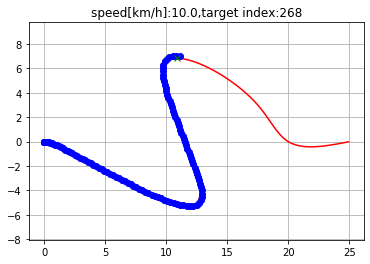

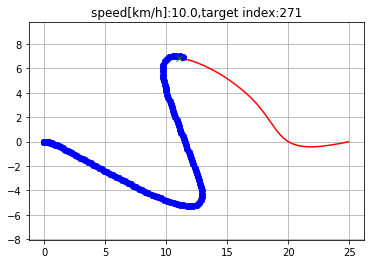

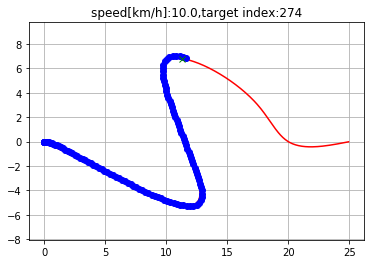

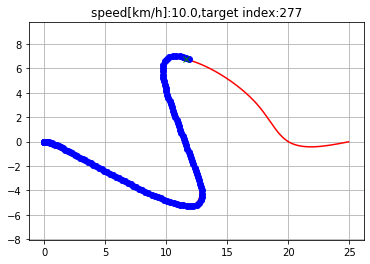

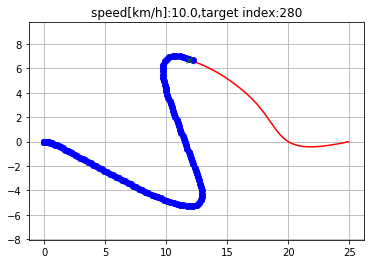

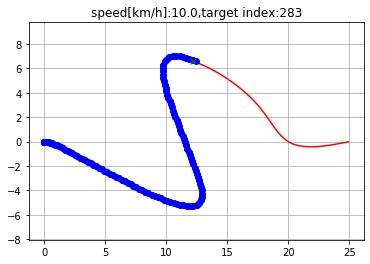

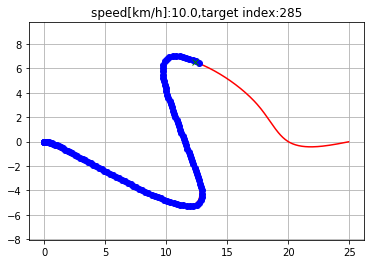

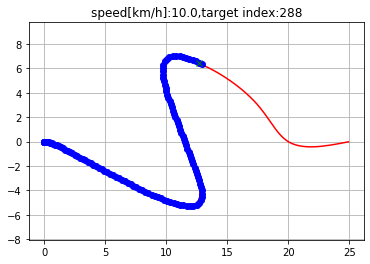

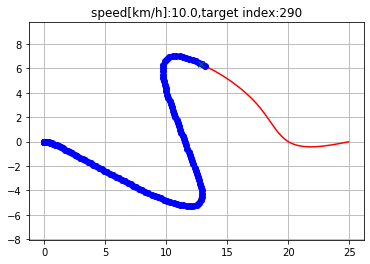

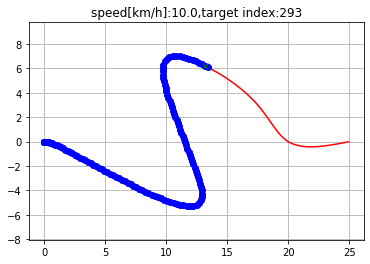

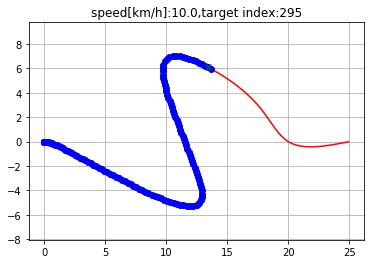

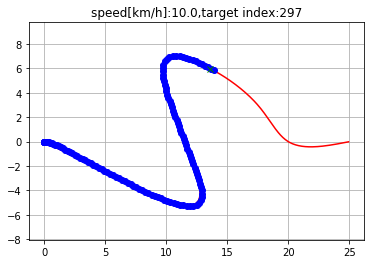

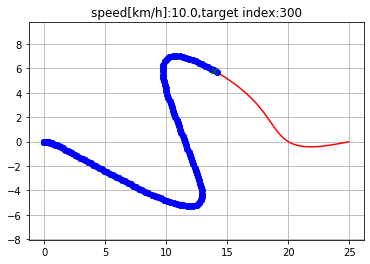

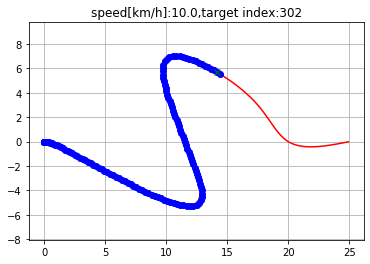

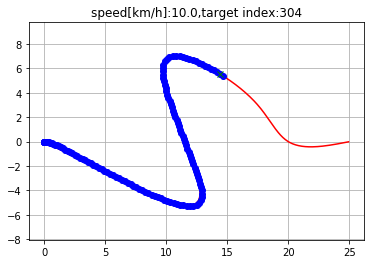

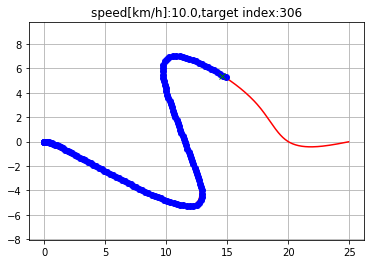

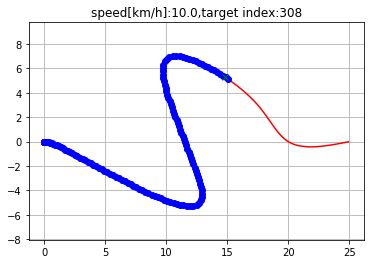

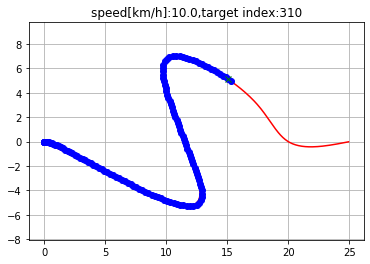

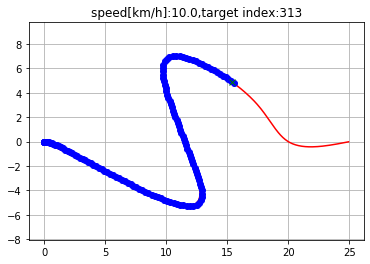

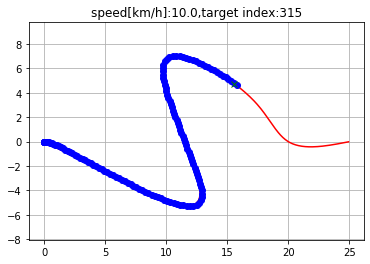

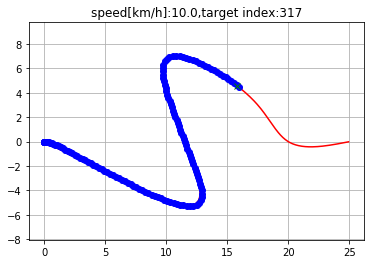

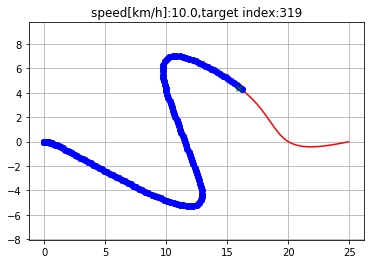

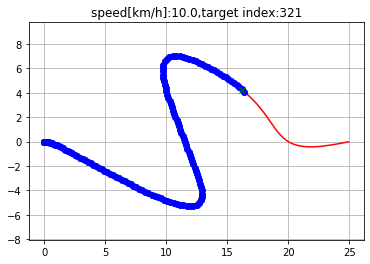

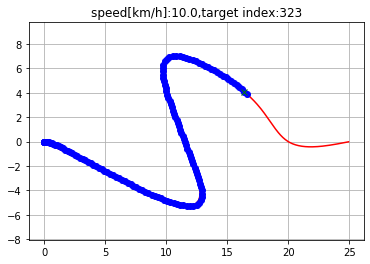

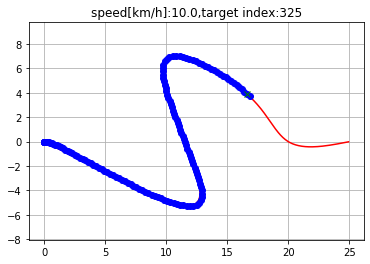

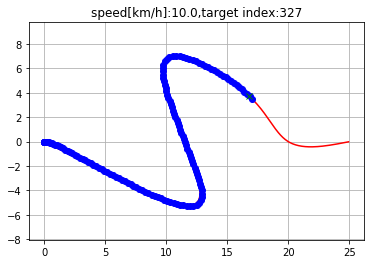

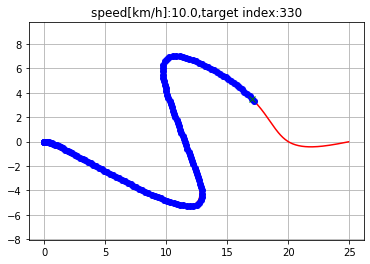

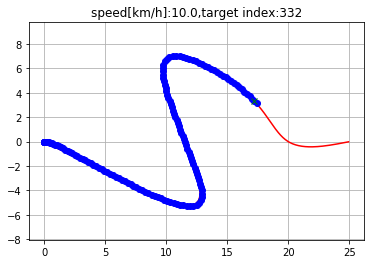

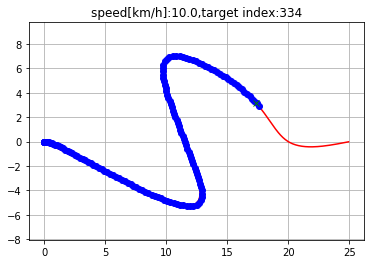

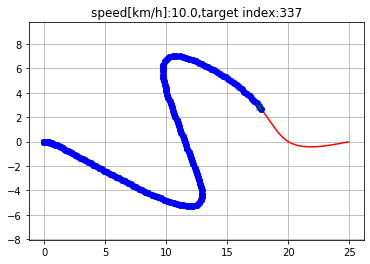

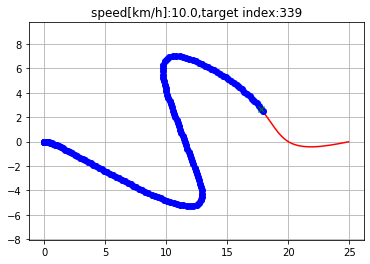

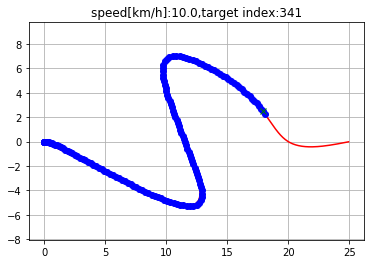

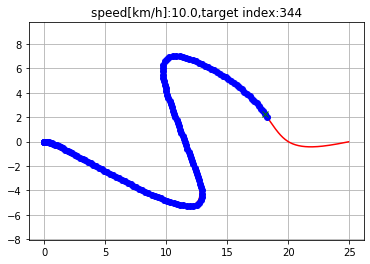

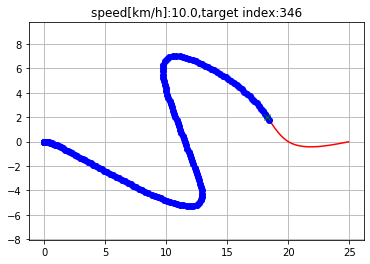

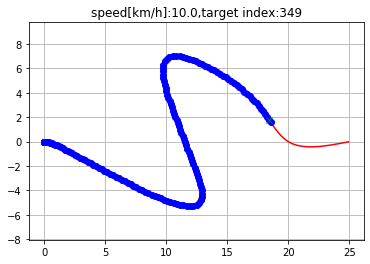

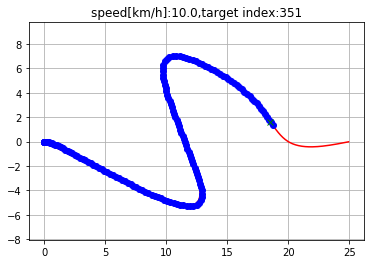

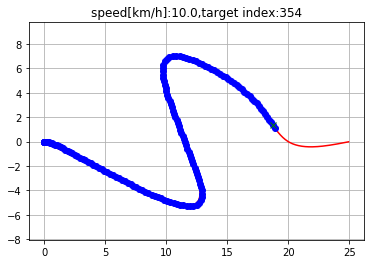

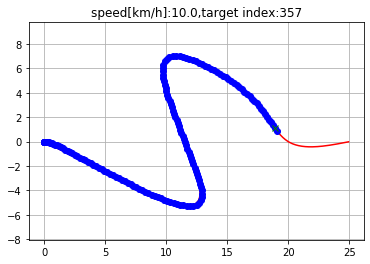

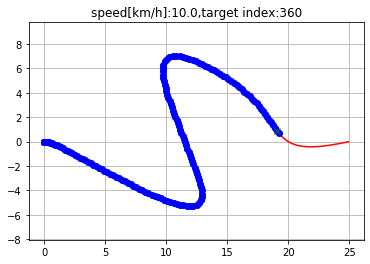

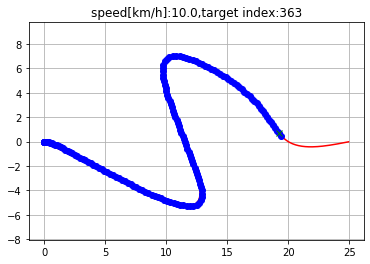

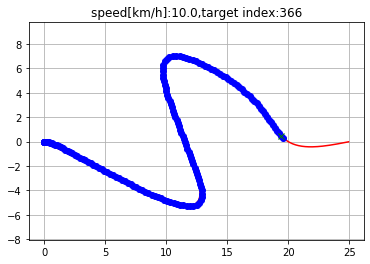

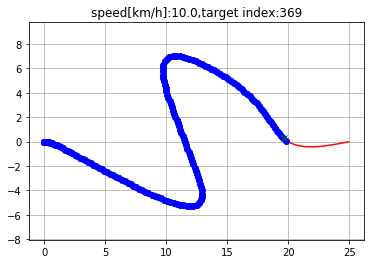

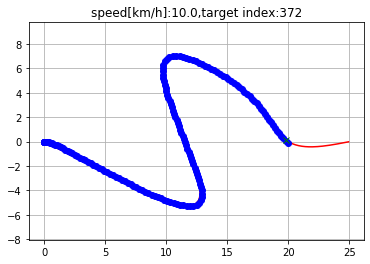

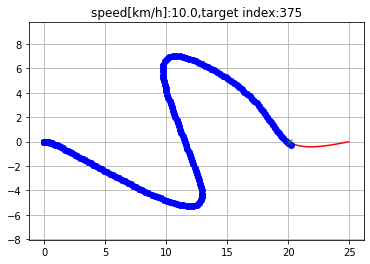

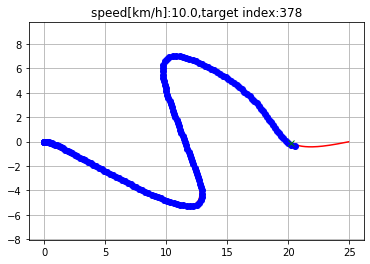

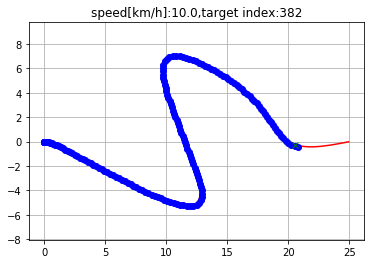

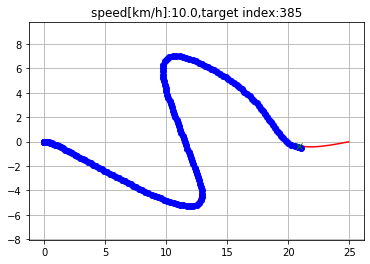

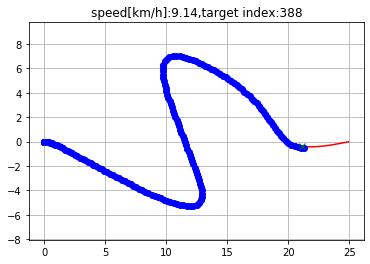

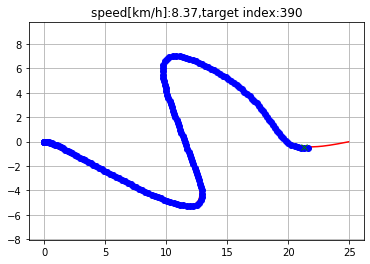

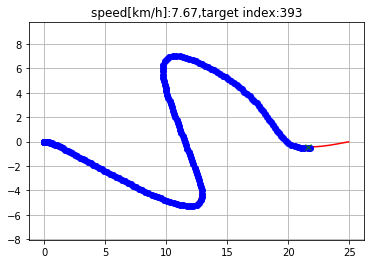

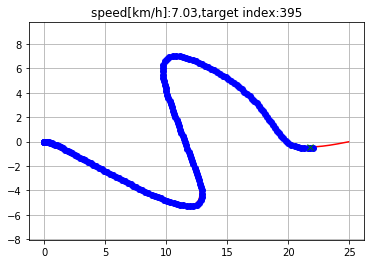

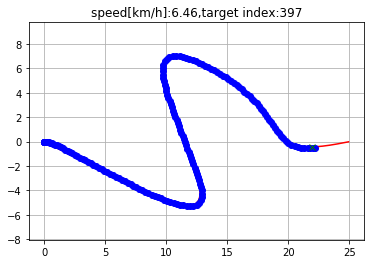

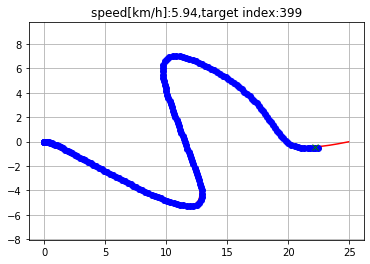

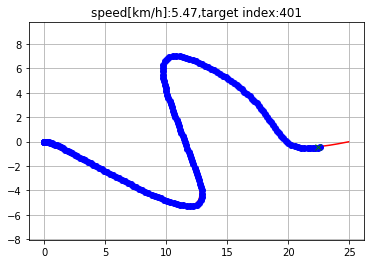

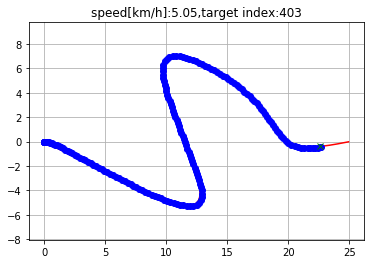

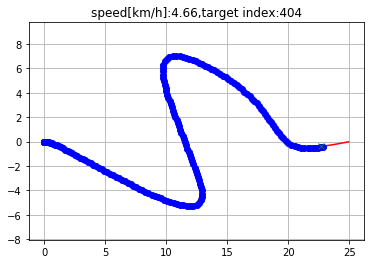

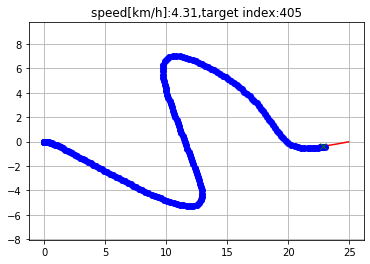

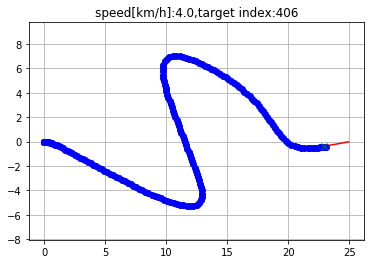

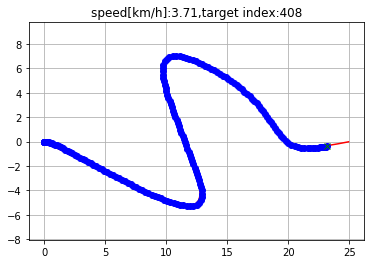

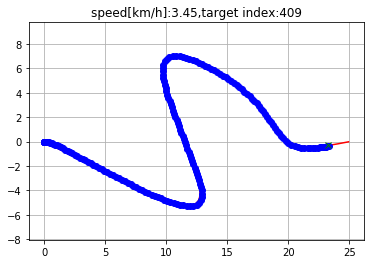

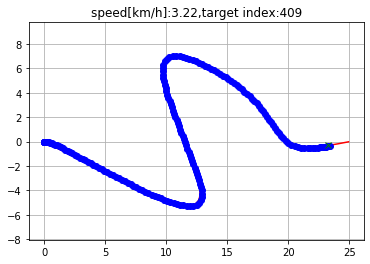

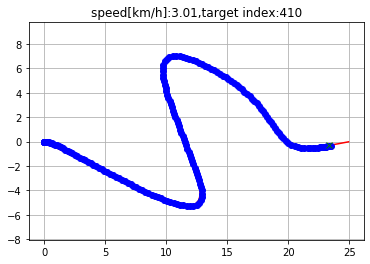

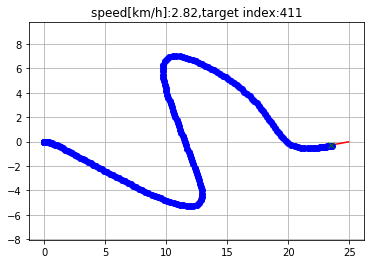

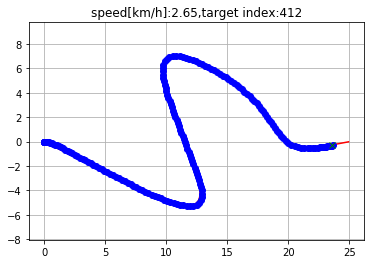

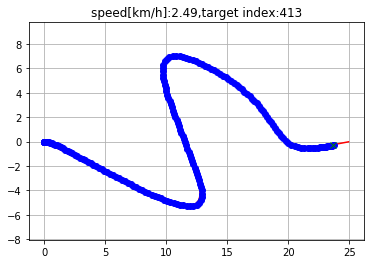

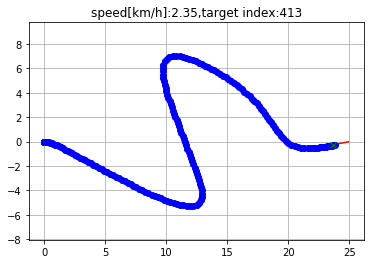

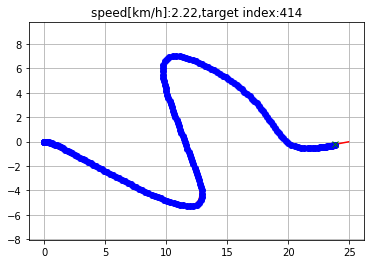

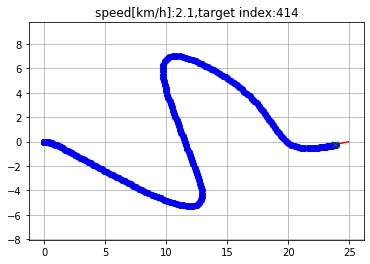

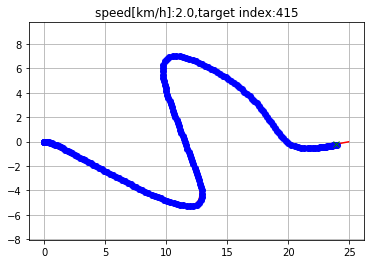

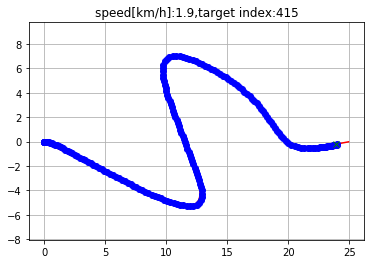

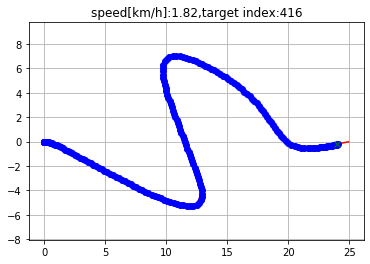

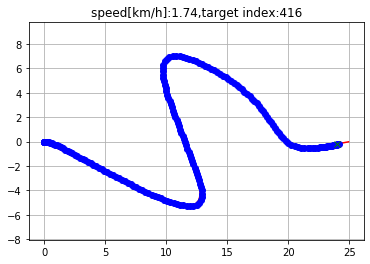

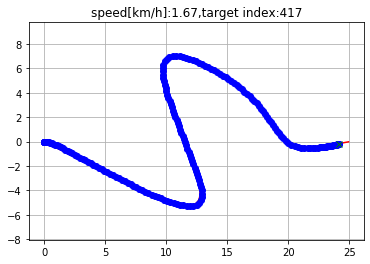

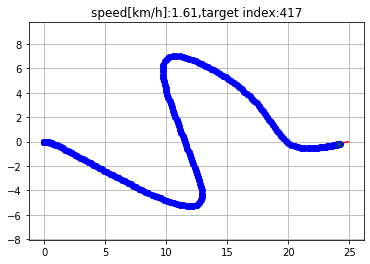

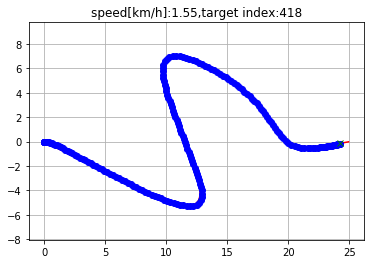

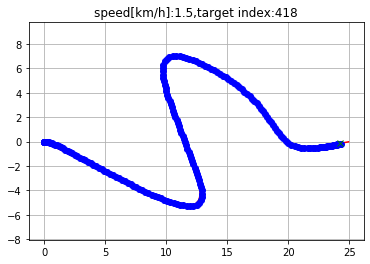

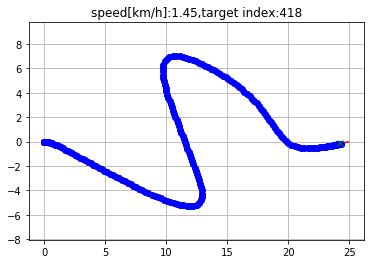

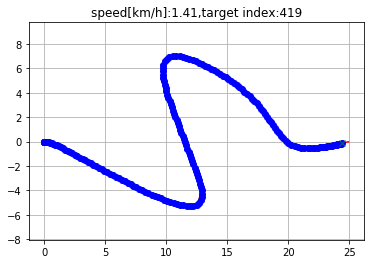

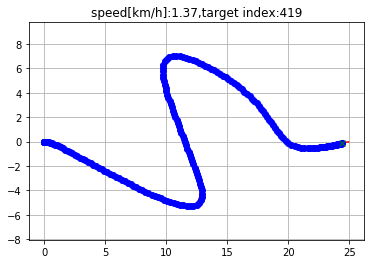

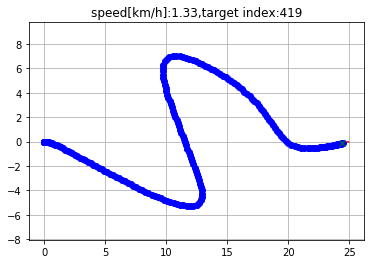

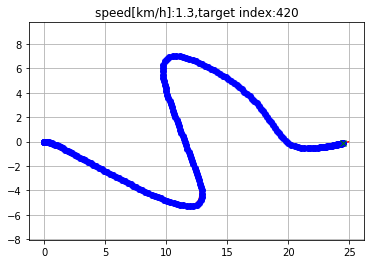

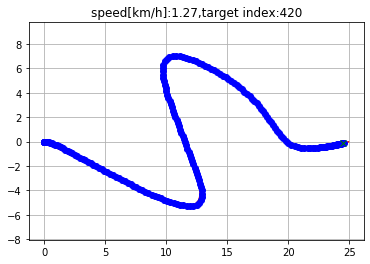

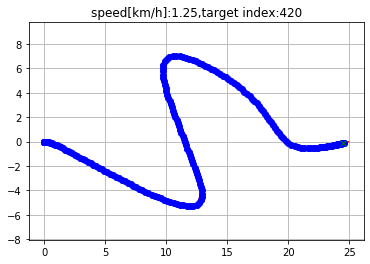

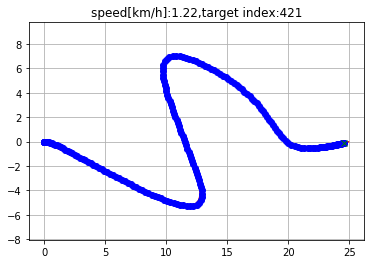

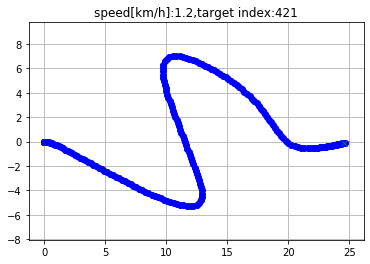

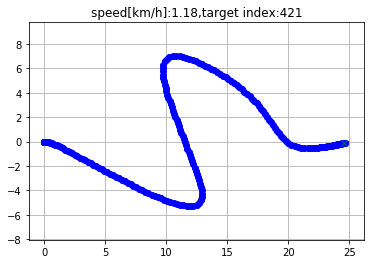

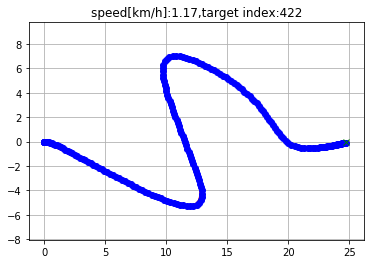

Goal


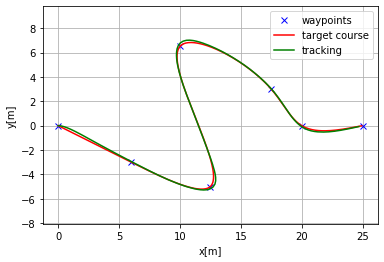

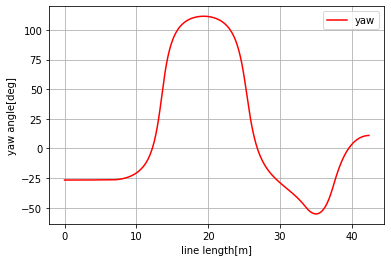

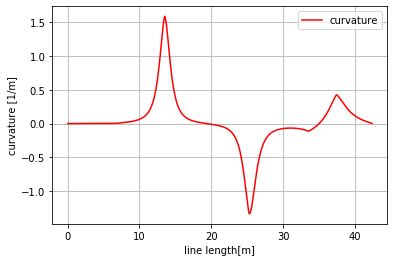

In [5]:
import math
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la



# === Parameters =====

# LQR parameter
lqr_Q = np.eye(5)
lqr_R = np.eye(2)
dt = 0.1  # time tick[s]
L = 0.5  # Wheel base of the vehicle [m]
max_steer = np.deg2rad(45.0)  # maximum steering angle[rad]

show_animation = True


class State:

    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v


def update(state, a, delta):

    if delta >= max_steer:
        delta = max_steer
    if delta <= - max_steer:
        delta = - max_steer

    state.x = state.x + state.v * math.cos(state.yaw) * dt
    state.y = state.y + state.v * math.sin(state.yaw) * dt
    state.yaw = state.yaw + state.v / L * math.tan(delta) * dt
    state.v = state.v + a * dt

    return state


def pi_2_pi(angle):
    return (angle + math.pi) % (2 * math.pi) - math.pi


def solve_dare(A, B, Q, R):
    """
    solve a discrete time_Algebraic Riccati equation (DARE)
    """
    x = Q
    x_next = Q
    max_iter = 150
    eps = 0.01

    for i in range(max_iter):
        x_next = A.T @ x @ A - A.T @ x @ B @ \
                 la.inv(R + B.T @ x @ B) @ B.T @ x @ A + Q
        if (abs(x_next - x)).max() < eps:
            break
        x = x_next

    return x_next


def dlqr(A, B, Q, R):
    """Solve the discrete time lqr controller.
    x[k+1] = A x[k] + B u[k]
    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    # ref Bertsekas, p.151
    """

    # first, try to solve the ricatti equation
    X = solve_dare(A, B, Q, R)

    # compute the LQR gain
    K = la.inv(B.T @ X @ B + R) @ (B.T @ X @ A)

    eig_result = la.eig(A - B @ K)

    return K, X, eig_result[0]


def lqr_speed_steering_control(state, cx, cy, cyaw, ck, pe, pth_e, sp, Q, R):
    ind, e = calc_nearest_index(state, cx, cy, cyaw)

    tv = sp[ind]

    k = ck[ind]
    v = state.v
    th_e = pi_2_pi(state.yaw - cyaw[ind])

    # A = [1.0, dt, 0.0, 0.0, 0.0
    #      0.0, 0.0, v, 0.0, 0.0]
    #      0.0, 0.0, 1.0, dt, 0.0]
    #      0.0, 0.0, 0.0, 0.0, 0.0]
    #      0.0, 0.0, 0.0, 0.0, 1.0]
    A = np.zeros((5, 5))
    A[0, 0] = 1.0
    A[0, 1] = dt
    A[1, 2] = v
    A[2, 2] = 1.0
    A[2, 3] = dt
    A[4, 4] = 1.0

    # B = [0.0, 0.0
    #     0.0, 0.0
    #     0.0, 0.0
    #     v/L, 0.0
    #     0.0, dt]
    B = np.zeros((5, 2))
    B[3, 0] = v / L
    B[4, 1] = dt

    K, _, _ = dlqr(A, B, Q, R)

    # state vector
    # x = [e, dot_e, th_e, dot_th_e, delta_v]
    # e: lateral distance to the path
    # dot_e: derivative of e
    # th_e: angle difference to the path
    # dot_th_e: derivative of th_e
    # delta_v: difference between current speed and target speed
    x = np.zeros((5, 1))
    x[0, 0] = e
    x[1, 0] = (e - pe) / dt
    x[2, 0] = th_e
    x[3, 0] = (th_e - pth_e) / dt
    x[4, 0] = v - tv

    # input vector
    # u = [delta, accel]
    # delta: steering angle
    # accel: acceleration
    ustar = -K @ x

    # calc steering input
    ff = math.atan2(L * k, 1)  # feedforward steering angle
    fb = pi_2_pi(ustar[0, 0])  # feedback steering angle
    delta = ff + fb

    # calc accel input
    accel = ustar[1, 0]

    return delta, ind, e, th_e, accel


def calc_nearest_index(state, cx, cy, cyaw):
    dx = [state.x - icx for icx in cx]
    dy = [state.y - icy for icy in cy]

    d = [idx ** 2 + idy ** 2 for (idx, idy) in zip(dx, dy)]

    mind = min(d)

    ind = d.index(mind)

    mind = math.sqrt(mind)

    dxl = cx[ind] - state.x
    dyl = cy[ind] - state.y

    angle = pi_2_pi(cyaw[ind] - math.atan2(dyl, dxl))
    if angle < 0:
        mind *= -1

    return ind, mind


def do_simulation(cx, cy, cyaw, ck, speed_profile, goal):
    T = 500.0  # max simulation time
    goal_dis = 0.3
    stop_speed = 0.05

    state = State(x=-0.0, y=-0.0, yaw=0.0, v=0.0)

    time = 0.0
    x = [state.x]
    y = [state.y]
    yaw = [state.yaw]
    v = [state.v]
    t = [0.0]

    e, e_th = 0.0, 0.0

    while T >= time:
        dl, target_ind, e, e_th, ai = lqr_speed_steering_control(
            state, cx, cy, cyaw, ck, e, e_th, speed_profile, lqr_Q, lqr_R)

        state = update(state, ai, dl)

        if abs(state.v) <= stop_speed:
            target_ind += 1

        time = time + dt

        # check goal
        dx = state.x - goal[0]
        dy = state.y - goal[1]
        if math.hypot(dx, dy) <= goal_dis:
            print("Goal")
            break

        x.append(state.x)
        y.append(state.y)
        yaw.append(state.yaw)
        v.append(state.v)
        t.append(time)

        if target_ind % 1 == 0 and show_animation:
            plt.cla()
            plt.plot(cx, cy, "-r", label="course")
            plt.plot(x, y, "ob", label="trajectory")
            plt.plot(cx[target_ind], cy[target_ind], "xg", label="target")
            plt.axis("equal")
            plt.grid(True)
            plt.title("speed[km/h]:" + str(round(state.v * 3.6, 2))
                      + ",target index:" + str(target_ind))
            plt.pause(0.0001)

    return t, x, y, yaw, v


def calc_speed_profile(cyaw, target_speed):
    speed_profile = [target_speed] * len(cyaw)

    direction = 1.0

    # Set stop point
    for i in range(len(cyaw) - 1):
        dyaw = abs(cyaw[i + 1] - cyaw[i])
        switch = math.pi / 4.0 <= dyaw < math.pi / 2.0

        if switch:
            direction *= -1

        if direction != 1.0:
            speed_profile[i] = - target_speed
        else:
            speed_profile[i] = target_speed

        if switch:
            speed_profile[i] = 0.0

    # speed down
    for i in range(40):
        speed_profile[-i] = target_speed / (50 - i)
        if speed_profile[-i] <= 1.0 / 3.6:
            speed_profile[-i] = 1.0 / 3.6

    return speed_profile


def main():
    print("LQR steering control tracking start!!")
    ax = [0.0, 6.0, 12.5, 10.0, 17.5, 20.0, 25.0]
    ay = [0.0, -3.0, -5.0, 6.5, 3.0, 0.0, 0.0]
    goal = [ax[-1], ay[-1]]

    cx, cy, cyaw, ck, s = calc_spline_course(
        ax, ay, ds=0.1)
    target_speed = 10.0 / 3.6  # simulation parameter km/h -> m/s

    sp = calc_speed_profile(cyaw, target_speed)

    t, x, y, yaw, v = do_simulation(cx, cy, cyaw, ck, sp, goal)

    if show_animation:  # pragma: no cover
        plt.close()
        plt.subplots(1)
        plt.plot(ax, ay, "xb", label="waypoints")
        plt.plot(cx, cy, "-r", label="target course")
        plt.plot(x, y, "-g", label="tracking")
        plt.grid(True)
        plt.axis("equal")
        plt.xlabel("x[m]")
        plt.ylabel("y[m]")
        plt.legend()

        plt.subplots(1)
        plt.plot(s, [np.rad2deg(iyaw) for iyaw in cyaw], "-r", label="yaw")
        plt.grid(True)
        plt.legend()
        plt.xlabel("line length[m]")
        plt.ylabel("yaw angle[deg]")

        plt.subplots(1)
        plt.plot(s, ck, "-r", label="curvature")
        plt.grid(True)
        plt.legend()
        plt.xlabel("line length[m]")
        plt.ylabel("curvature [1/m]")

        plt.show()


if __name__ == '__main__':
    main()
